<a href="https://colab.research.google.com/github/MissFengPhyllis/homeworkAndProject/blob/master/Another_assignment_Fruits20200514.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework assignment - Fruits
This notebook is the stub you have to fill out for the homework. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier from loading and inspecting the dataset to making something working. The section descriptions contain what to do in that step.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to canvas.elte.hu or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

Note Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Task description
Your task is to implement a deep learning classifier of fruit images. The dataset contains segmented images of 60 different fruits. You'll have to implement a convolutional network.

## Rules and Comments
This is an ML class so to pass the homework you do have to implement a working classifier, just loading the data is not enough.
As always, copying others' code will make you fail the homework automatically (and thus the course)
Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
Please add your name and Neptun ID in the box below for easier identification.

**Name: Feng Lijiao**

**Neptun ID: H2MI9D**

In [0]:
# Keras 2.3.1 has a bug in evalutation, downgrade it
%tensorflow_version 1.x
!pip install -U keras==2.2.5

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 2.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
!wget http://vegesm.web.elte.hu/fruits_small.zip
!unzip fruits_small.zip > /dev/null

--2020-05-12 08:50:28--  http://vegesm.web.elte.hu/fruits_small.zip
Resolving vegesm.web.elte.hu (vegesm.web.elte.hu)... 157.181.1.225
Connecting to vegesm.web.elte.hu (vegesm.web.elte.hu)|157.181.1.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186322919 (178M) [application/zip]
Saving to: ‘fruits_small.zip’

fruits_small.zip    100%[===================>] 177.69M  4.04MB/s    in 3m 7s   

2020-05-12 08:53:36 (974 KB/s) - ‘fruits_small.zip’ saved [186322919/186322919]



In [0]:
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage import color,data,transform,io
from sklearn.utils import shuffle
import keras
from keras.utils import np_utils

Save the path and separate the paths of the test set and the training set

In [0]:
data_dir = "/content/fruits-small/" 
train_dir = data_dir + "train/"
validation_dir = data_dir + "test/"

In [0]:
##Get the picture data under the corresponding path folder
def load_data(dir_path):
    images=[] ##Create an empty list to store the picture collection
    labels=[] ##Create an empty list to store the tag set
    no5_imgs=[] ##Create an empty list to store the fifth picture under each folder
    labels_no5=[] ##Create an empty list to store the folder name corresponding to the fifth picture
    lab=os.listdir(dir_path)
    n=0
    for l in lab:
      img=os.listdir(dir_path+l) ##img is the folder under the corresponding path
      for i in img:
          img_path=dir_path+l+'/'+i ##If yes, get the image path
          labels.append(int(n)) ##Store the iteration number n of the outer loop in labels
          images.append(skimage.io.imread(img_path)) ##Read the corresponding path image and store it in datasets
      n+=1
      no5_img=format_path(img) ##Arrange the pictures in the correct order to facilitate the fifth picture
      img5_path=dir_path+l+'/'+no5_img
      labels_no5.append(l)
      no5_imgs.append(skimage.io.imread(img5_path)) ##The fifth picture of each category is read out and stored in the data set no5_imgs
    return images,labels,no5_imgs,labels_no5 ##The storage order of the images in the returned images is different from the storage order in the actual folder

In [0]:
##Function for sequentially reading files in a folder
def format_path(img):  ## img is the result of os.listdir (label folder)   
    yes_int=[] ##The new list is used to store the file name of the first item that can be converted into an integer
    for s in range(len(img)): ##Iterate
        img[s] = img[s].split('_') ##Separate file names with "_" as a separator
        if(is_number(img[s][0])): ##Determine whether the first part of the file name can be converted to an integer
            img[s][0]=int(img[s][0]) ##Convert the first part of the file name to an integer
            yes_int.append(img[s]) ##Put the file name in the list without r
    yes_int.sort() ##Sort the list of file names that can be converted to integer
    for yi in range(len(yes_int)): ##variable
        yes_int[yi][0]=str(yes_int[yi][0]) ##Convert the previous part to integer and then back to the string
        yes_int[yi]=yes_int[yi][0]+'_'+yes_int[yi][1] ##Perform stitching
    no5_img=yes_int[4]
    return no5_img

In [0]:
##Determine whether a piece of data can be converted to plastic
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [0]:
##Final train data set and label
images,labels,no5_imgs,labels_no5 = load_data(train_dir)
print(len(images),len(labels),len(no5_imgs))

30468 30468 60


In [0]:

##Final test data set and label
images_test,labels_test,no5_imgs_test,labels_no5_test = load_data(validation_dir)
print(len(images_test),len(labels_test),len(no5_imgs_test),len(labels_no5_test))

10332 10332 60 60


In [0]:
##Define the fifth picture visualization function
import random
def display_no5_img(no5_imgs,labels_no5):
    fig = plt.figure(figsize=(15,15)) ##The displayed size is15*15
    for i in range(len(labels_no5)):
        plt.subplot(11,7,(i+1)) ##Displayed as 11 lines, 7 per line
        plt.title("{0}".format(labels_no5[i])) ##Show title
        plt.imshow(no5_imgs[i])  ##display image
        plt.axis('off') ##Don't show axis
    plt.show()

In [0]:
##Call display function
import random
def display_no5_img_4(dict_no5):
  fig = plt.figure(figsize=(15,15)) ##The displayed size is 15*15
  for i in range(len(dict_no5)):
    # print(i) //Subscript of dictionary list
    # print(dict_list_no5[i][0])//Picture title
    # print(dict_list_no5[i][1])//Picture matrix
    plt.subplot(11,7,(i+1))
    label = dict_no5[i][0]
    img = dict_no5[i][1]
    plt.title("{0}".format(label))
    plt.imshow(img)
  plt.show()

show random 4 picture and the class name

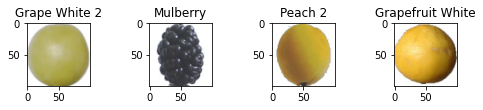

In [0]:
dict_no5 = zip(labels_no5,no5_imgs)
dict_list_no5 = list(dict_no5) 
random_list = random.sample(dict_list_no5,4)
display_no5_img_4(random_list)

Since the data set of 77 kinds of fruits has more than 30,000 pictures, my computer can't bear the training of so many pictures, so I only select the first 20 categories in the dataset for training

Preprocess the dataset
We need to augment the data, since we do not have many images per classes. Create an augmentation mechanism, data automatically does the following transformations during training:

flip images horizontally
rotates them
performs zooming

In [0]:
##Since the data set is too large, first load a small part for training, n represents several classes
def load_small_data(dir_path,m):
    images_m=[] ##Create an empty list to store the picture collection
    labels_m=[] ##Create an empty list to store the tag set
    lab=os.listdir(dir_path)
    n=0
    for l in lab:
        if(n>=m):
            break
        img=os.listdir(dir_path+l) ##img is the folder under the corresponding path
        for i in img:
            img_path=dir_path+l+'/'+i ##If yes, get the image path
            labels_m.append(int(n)) ##Convert the upper folder of the picture to int type and store it in labels
            images_m.append(skimage.io.imread(img_path)) ##Read the corresponding path image and store it in images_m
        n+=1
    return images_m,labels_m ## Class m labels and data

In the field of image processing, there are many ways, such as image denoising, translation, inversion, grayscale, cropping, etc., there will be some related processing functions below, but I did not use it in this experiment These above-mentioned processing methods simply convert the image data set into an array form, and chase it out of order, and perform keras unique encoding on the transition data set. I have used the grayscale image data set to train the model, and the result is that the accuracy of the test set prediction is reduced

In [0]:
images_20,labels_20=load_small_data(train_dir,20) ##Training set
images_test_20,labels_test_20=load_small_data(validation_dir,20) ##Test set

In [0]:
##Use list comprehension to complete batch cropping of images
def cut_image(images,w,h):
    new_images=[skimage.transform.resize(I,(w,h)) for I in images]
    return new_images

In [0]:
##Preprocessing data functions (arraying, out of order)
def prepare_data(images,labels,n_classes):
    ##images64=cut_image(images,64,64) ##Crop picture size is 64 * 64
    train_x=np.array(images)
    train_y=np.array(labels)
    ##images_gray=color.rgb2gray(images_a) ##Grayscale
    indx=np.arange(0,train_y.shape[0])
    indx=shuffle(indx)
    train_x=train_x[indx]
    train_y=train_y[indx]
    train_y=keras.utils.to_categorical(train_y,n_classes) ##one-hot coding
    return train_x,train_y

In [0]:
##Training set data preprocessing
train_x,train_y=prepare_data(images_20,labels_20,20)
##Test data set and label array and out of order
test_x,test_y=prepare_data(images_test_20,labels_test_20,20)

## Construction of Tensorflow convolutional neural network
My convolutional neural network is a two-layer convolution pooling built with the classic model LeNet-5 model, three layers are fully connected, and the code has detailed comments


Training the network
Implement and train the following architecture. It has the following layers:

A convolutional layer with 5x5 kernel and 32 filters
A 2x2 MaxPooling layer
Two convolutional layers with 3x3 kernels and 64 filters each
A MaxPooling layer
Another 3x3 convolutional layer with 128 filters, followed by a MaxPooling layer
A fully connected layer of 512 units
A final softmax layer
All layers have ReLU activations. Train the network for 15 epochs.

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
## Configure the parameters of the neural network
n_classes=20 ##Number of data categories
batch_size=128 ##Training block size
kernel_h=kernel_w=5 ##Convolution kernel size
dropout=0.8 ##dropout probability
depth_in=3 ##Picture channels
depth_out1=64 ##Number of convolution kernels in the first layer of convolution
depth_out2=128 ##Number of convolution kernels in the second layer of convolution
image_size=train_x.shape[1] ##size of the picture
n_sample=train_x.shape[0] ##Number of training samples
t_sample=test_x.shape[0] ##Number of test samples
 
##Feed image data types and shapes for neural networks, four-dimensional, the amount of training data in the first dimension, the size of the second and three-dimensional pictures,
# and the number of image channels in the fourth dimension
x=tf.placeholder(tf.float32,[None,100,100,3]) 
y=tf.placeholder(tf.float32,[None,n_classes]) ##The type and shape of label data feed to the neural network
keep_prob=tf.placeholder(tf.float32) ##ddropout placeholder (solve overfitting)
fla=int((image_size*image_size/16)*depth_out2) ##The size of the image used for the flattening process after
# the two-layer convolution pooling * the number of convolution kernels in the second layer defines the weight variables of each convolution layer and the fully connected layer
Weights={"con1_w":tf.Variable(tf.random_normal([kernel_h,kernel_w,depth_in,depth_out1])),
         "con2_w":tf.Variable(tf.random_normal([kernel_h,kernel_w,depth_out1,depth_out2])),
        "fc_w1":tf.Variable(tf.random_normal([int((image_size*image_size/16)*depth_out2),1024])),
        "fc_w2":tf.Variable(tf.random_normal([1024,512])),
        "out":tf.Variable(tf.random_normal([512,n_classes]))}
 
##Define offset variables for each convolutional layer and fully connected layer
bias={"conv1_b":tf.Variable(tf.random_normal([depth_out1])),
      "conv2_b":tf.Variable(tf.random_normal([depth_out2])),
      "fc_b1":tf.Variable(tf.random_normal([1024])),
      "fc_b2":tf.Variable(tf.random_normal([512])),
      "out":tf.Variable(tf.random_normal([n_classes]))}

In [0]:
## Define the generation function of the convolutional layer
def conv2d(x,W,b,stride=1):
    x=tf.nn.conv2d(x,W,strides=[1,stride,stride,1],padding="SAME")
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)
 
## Define the generation function of the pooling layer
def maxpool2d(x,stride=2):
    return tf.nn.max_pool(x,ksize=[1,stride,stride,1],strides=[1,stride,stride,1],padding="SAME")
 
## Define the generation function of convolutional neural network
def conv_net(x,weights,biases,dropout):
    
    ## Convolutional layer 1
    conv1 = conv2d(x,Weights['con1_w'],bias['conv1_b']) ##100*100*64
    conv1 = maxpool2d(conv1,2) ##After pooling layer 1 shape：50*50*64
     
    ## Convolutional layer 2
    conv2 = conv2d(conv1,Weights['con2_w'],bias['conv2_b']) ##50*50*128
    conv2 = maxpool2d(conv2,2) ##After pooling layer 2 shape:25*25*128
    ## Fully connected layer 1(
    flatten = tf.reshape(conv2,[-1,fla]) ##Flatten
    fc1 = tf.add(tf.matmul(flatten,Weights['fc_w1']),bias['fc_b1'])
    fc1 = tf.nn.relu(fc1) ##After relu activation function
    print(flatten.get_shape())
    ## Fully connected layer 2
    fc2 = tf.add(tf.matmul(fc1,Weights['fc_w2']),bias['fc_b2']) ##Calculation formula: output parameter = input parameter * weight + offset
    fc2 = tf.nn.relu(fc2) ##After relu activation function
    
    ## Dropout layer prevents overfitting of predicted data
    fc2 = tf.nn.dropout(fc2,dropout)
    ## Output class prediction
    prediction = tf.add(tf.matmul(fc2,Weights['out']),bias['out']) ##Output prediction parameters
    return prediction

In [0]:
## Optimize prediction accuracy
prediction=conv_net(x,Weights,bias,keep_prob) ##Generate convolutional neural network
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y)) ##Cross entropy loss function
optimizer=tf.train.AdamOptimizer(0.0009).minimize(cross_entropy) ##Choose optimizer and learning rate
##optimizer=tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
##optimizer=tf.train.AdagradOptimizer(0.001).minimize(cross_entropy) ##Choose optimizer and learning rate
 
## Evaluation model
correct_pred=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))

(?, 80000)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Here is a small function to divide the training data into n pieces of small data and feed it to the neural network

In [0]:
##Training block data generator
def gen_small_data(inputs,batch_size):
    i=0
    while True:
        small_data=inputs[i:(batch_size+i)]
        i+=batch_size
        yield small_data

Training data and view the accuracy of the model on the test set

Finally, calculate the performance of your model on the test set:

In [0]:
## Initial session and start training process
with tf.Session() as sess:
    tf.global_variables_initializer().run()   
    for  i  in range(5):
        train_x,train_y=prepare_data(images_20,labels_20,20) ##Re-process data
        train_x=gen_small_data(train_x,batch_size) ##Generate image block data
        train_y=gen_small_data(train_y,batch_size) ##Generate label block data
        for j in range(int(n_sample/batch_size)+1):
            x_=next(train_x) 
            y_=next(train_y)
            ##Prepare verification data
            validate_feed={x:x_,y:y_,keep_prob:0.8}
            if i % 1 == 0:
                sess.run(optimizer, feed_dict=validate_feed)
                loss,acc = sess.run([cross_entropy,accuracy],feed_dict={x:x_,y:y_,keep_prob:0.8})
                print("Epoch:", '%04d' % (i+1),"cost=", "{:.9f}".format(loss),"Training accuracy","{:.5f}".format(acc))
    print('Optimization Completed')
    ##Prepare test data
    test_x=test_x[0:400]
    test_y=test_y[0:400]
    test_feed={x:test_x,y:test_y,keep_prob: 0.8} 
    y1 = sess.run(prediction,feed_dict=test_feed)
    test_classes = np.argmax(y1,1)
    print('Testing Accuracy:',sess.run(accuracy,feed_dict=test_feed))

Epoch: 0001 cost= 5273939968.000000000 Training accuracy 0.05469
Epoch: 0001 cost= 5227146752.000000000 Training accuracy 0.09375
Epoch: 0001 cost= 4303745024.000000000 Training accuracy 0.07812
Epoch: 0001 cost= 3626212608.000000000 Training accuracy 0.10938
Epoch: 0001 cost= 3233377280.000000000 Training accuracy 0.10938
Epoch: 0001 cost= 3402319360.000000000 Training accuracy 0.10156
Epoch: 0001 cost= 2790237184.000000000 Training accuracy 0.17969
Epoch: 0001 cost= 2929535488.000000000 Training accuracy 0.10156
Epoch: 0001 cost= 2273450496.000000000 Training accuracy 0.19531
Epoch: 0001 cost= 2472119808.000000000 Training accuracy 0.14844
Epoch: 0001 cost= 1696453376.000000000 Training accuracy 0.20312
Epoch: 0001 cost= 1579098496.000000000 Training accuracy 0.17188
Epoch: 0001 cost= 1449255680.000000000 Training accuracy 0.21094
Epoch: 0001 cost= 1155407360.000000000 Training accuracy 0.29688
Epoch: 0001 cost= 1499905536.000000000 Training accuracy 0.22656
Epoch: 0001 cost= 1194873

## Summary
My experiment only tested 20 kinds of fruits in the end, because my computer's configuration is not very good, and then it took about an hour to finish the optimization.